# <font size=10 color=blue> Влияние глубокого обучения на выделение объектов </font>
![Segmentation](./img/Detection01.png)

О том, что такое mAP в детекции: https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

# Проблема классификации
![Segmentation](./img/Detection02.ex.png)
<font color=blue size=5>Объектов на картинке много. Как идентифицировать объекты?</font>

## Часть первая, классификация с локализация объектов. 
- Известно, что картинка содержит один объект класса 
- Хотим определить решить две задачи 
    1. Классифицировать объект
    2. Найти кго место положение на изображении
    
Для решения задачи, как правило используют базу данных уже размеченных изображений, каждое изображение 
- a. Имеет метку класса
- b. Имеет разметку, где находится объект, как правило, это обрамляющий четырех угольник *bounding box*


* существуют большие дата сеты с разметкой изображений bounding box -ами
 - COCO
 - [Pascal Voc](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/index.html)
 - ImageNet, kagle

### Небольшой игрушечный датасет для пробы

In [2]:
import os
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpim
import matplotlib.patches as mpatches
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.animation as animation

%matplotlib inline

Аннотации в формате pascal voc, т.е. это обычный xml с определенными полями, можно вскрыть и посмотреть. Ниже код который читает этот формат. Еще один формат - это COCO.

In [3]:
# загрузка аннотации картинки
def load_annotation(img_filename):
    xml = ""
    file = annotation_file_from_img(img_filename)
    if not os.path.exists(file): return None
    with open(file) as f:
        xml = f.readlines()
    xml = ''.join([line.strip('\t') for line in xml])
    return BeautifulSoup(xml, "html5lib")

# сделаем из имени файла имя файла аннотации
def annotation_file_from_img(img_name):
    return os.path.join(ANNOTATIONS, img_name) + '.xml'


# получить данные из файла аннотации
def load_data(images):        
        data = []
        for item in images:
            anno = load_annotation(item)
            if not anno: continue
            objs = anno.findAll('object')
            # в случае если объектов на картинке 
            # много, но это не про нас
            for obj in objs:
                obj_names = obj.findChildren('name')
                for name_tag in obj_names:
                    fname = anno.findChild('filename').contents[0]
                    fname = os.path.splitext(fname)[0] # удалим расширение
                    bbox = obj.findChildren('bndbox')[0]
                    xmin = int(bbox.findChildren('xmin')[0].contents[0])
                    ymin = int(bbox.findChildren('ymin')[0].contents[0])
                    xmax = int(bbox.findChildren('xmax')[0].contents[0])
                    ymax = int(bbox.findChildren('ymax')[0].contents[0])
                    data.append([fname, xmin, ymin, xmax, ymax])
        df = pd.DataFrame(
            data, columns=['fname', 'xmin', 'ymin', 'xmax', 'ymax'])
        df = df.set_index('fname')
        return df


Определяем каталоги где лежат картинки и аннотации, и читаем список картинок, и загружаем аннотации в pandas DataFrame

In [4]:
ANNOTATIONS = './annotations/'
IMAGES = './images/'
image_files = [ os.path.splitext(f)[0] for f in os.listdir(IMAGES) if os.path.splitext(f)[1] == '.jpg'] 
data = load_data(image_files)
print ("Total images", len(data))
data.head()

Total images 99


,xmin,ymin,xmax,ymax
fname,,,,
toy10,122,44,277,252
toy100,163,77,314,231
toy101,176,93,324,242
toy102,162,56,312,224
toy103,195,73,322,210


Выводим картинки с обрамляющими * bounding box * -ми 

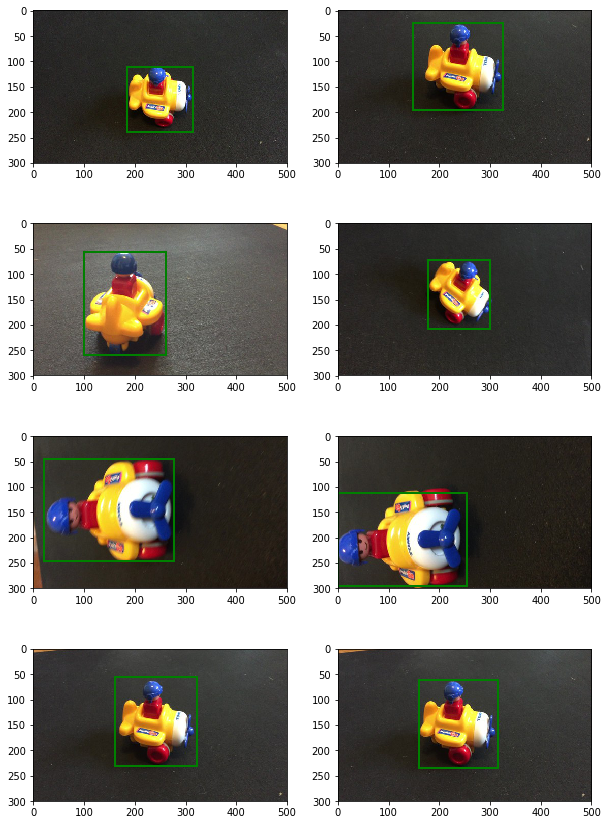

In [5]:
size = 8
# берем size случайных картинок
sample = np.random.choice(np.linspace(0, len(image_files)-1, len(image_files), dtype=int), replace=False, size=size)
plt.figure(figsize=(10, 15))
for num in range(1, size+1):
    #имя файла это индекс в дата сете
    idx = image_files[sample[num-1]]    
    ax = plt.subplot(4,2,num) 
    # читаем b gjrfpsdftv rfhnbyrb 
    img = mpim.imread(os.path.join(IMAGES, idx + '.jpg'))
    ax.imshow(img)
    # задаем положение bb
    x, y, w, h = data.loc[idx]['xmin'], data.loc[idx]['ymin'], data.loc[idx]['xmax'], data.loc[idx]['ymax']
    w, h = w - x, h-y
    rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)


Теперь мы имеем размеченный дата сет для нашей задачи локализации объектов.

Задача классификация, предполагает, что сеть имеет *softmax* слой, который выдает вероятности объектов. Для классификации игрушки это выглядит примерно так:
![Segmentation](./img/Classification_toy.png)

In [55]:
"""
небольшой скетч нейросети для такой классификции
"""
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=2)
                                 # ну и что то еще,
                                )
        # ....
        self.linear_input = None # размер финального слоя CNN -> count_features x out_W x out_H
        self.classes = nn.Linear(self.linear_input, 2) # два класса 
        
    def forward(self, x):
        o = self.net(x)
        o = o.view(-1, self.linear_input)
        return self.classes(o) # возвращаем два logit'а для оценки, при помощи nn.Softmax()

Что делать если мы хотим научится находить игрушку на картинке? Добавим еще координаны _bounding box_.
![Segmentation](./img/Localization_toy.png)

$\large b_x, b_y\ -\ координаты\ центра\ прямоугольника \\
\large b_w, b_h\ -\ ширина\ и\ высота\ прямоугольника
$


In [56]:
"""
небольшой скетч нейросети для такой классификции, и нахождения координат bounding box
"""
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=2)
                                 # ну и что то еще,
                                )
        # ....
        self.linear_input = None # размер финального слоя CNN -> count_features x out_W x out_H
        self.classes = nn.Linear(self.linear_input, 2) # два класса 
        self.bb      = nn.Linear(self.linear_input, 4) # координаты ограничивающего прямоугольника
        
    def forward(self, x):
        o = self.net(x)
        o = o.view(-1, self.linear_input)
        return self.classes(o), self.bb(o) # возвращаем два logit'а для оценки, при помощи nn.Softmax() и координаты

Для задачи определения координат можно решить задачу регрессии и минимизировать L2 loss:

$ \large L = \frac{1}{N} \times \sum_i {((y_i^x-\hat{y_i^x})^2 + (y_i^y-\hat{y_i^y})^2)} $

Разницу между координатами таргета и предсказанными сетью.

``` python
nn.MSELoss() # реализует L2 лосс
```

*Для нашей задачи можно обойтись без части классификации, так как у нас нет картинок с чистым фоном.*

### Общий случай
1. Нужно определить есть объект на картинке или нет, т.е. нам нужна вероятность наличие обекта класса $\large p_c$
2. Нам нужны координаты ограничивающего прямоугольника. $\large b_x, b_y, b_w, b_h $
3. Нам нужны признаки классов, для каждого класса $c_1, c_2, c_3, ... , c_k$

Тогда выход нашей сети будет выглядеть вот так 
$ \ \large y = \left[ p_c, b_x, b_y, b_w, b_h, c_1, c_2, c_3, ... , c_k \right]$

### Пример 
Задача локализовать следующие объекты
1. Авто
2. Пешеход
3. Мотоцикл

$ \large k=3 $
---
Вход  $\large x => $ 
![Segmentation](./img/Localization_car.png)

Выход
$ \ \large y = \left[ 1, b_x, b_y, b_w, b_h, 1, 0, 0 \right]$

---
Вход  $\large x => $ 
![Segmentation](./img/Localization_nocar.png)

Выход
$ \ \large y = \left[ 0, ?, ?, ?, ?, ?, ?, ? \right]$

### Функция потерь
$\large L =  \begin{cases}
   L_{mce} + L_{ce} + L_{bce}, & \text{if} \ p_c = 1 \\
   L_{bce}, & \text{if} \ p_c = 0 
   \end{cases}
$

$L_{mse} $ - MSE по координатам bounding box

$L_{ce}$ - кросс энтропия по объектам

$L_{bce}$ - бинарная кросс энтропия для детекции объекта на картинке

# Часть вторая. Детекция ключевых точек.
Если сеть может определеить координаты ограрничивающего прямоугольника, то почему бы нам не решить задачу нахождения ключевых точек объектов.
Пример:
[Deepfashion](http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion/LandmarkDetection.html) - разметка ключевых точек одежды
![Segmentation](./img/Landmarks-Fashion.png)

Каждая картинка имеет разметку ключевых точек, в зависимости от типа одежды, каждая ключевая точка имеет координату расположения на картинке $l_{ix} ,l_{iy}$. Если мы хотим решить задачу идентификации ключевых точек на одежде, то нам нужно
1. Определить есть ли на картинке одежда $p_c$
2. Определить тип одежды $c_1, c_2, c_3$, (upper, full, lowwer - body)
3. Определить точки $l_{1x}, l_{1y}, ,..., l_{nx}, l_{ny}$

Наш таргет тогда будет выглядеть следующим образом:
$ y = \left[p_c, c_1, c_2, c_3, l_{1x}, l_{1y}, ,..., l_{nx}, l_{ny} \right]$

### Функция потерь
$\large L =  \begin{cases}
   L_{mce} + L_{ce} + L_{bce}, & \text{if} \ p_c = 1 \\
   L_{bce}, & \text{if} \ p_c = 0 
   \end{cases}
$

$L_{mse} $ - MSE по координатам ключевых точек

$L_{ce}$ - кросс энтропия по объектам

$L_{bce}$ - бинарная кросс энтропия для детекции одежды

# Можно даже решить таким образом задачу "Pose detection"
![Segmentation](./img/Landmarks-Pose.png)

# Часть третья. Детекция объектов.

## Sliding windows

Мы хотим усложнить задачу и определять не один объект на картинке, а определять, например все авто на изображении.
![Segmentation](./img/Detection_cars.pmg.png)

Для этого нам понадобится натренировать сеть для распознавания изображений авто, по некоторому датасету 
1 - Авто
0 - Не авто
![Segmentation](./img/Detection_cars_class.png)

Теперь можем проделать с изображением следующее: пробежать по изображению патчами разного размера и проклассифицировать каждый патч на авто и не авто, при помощи нашей нейросети. 

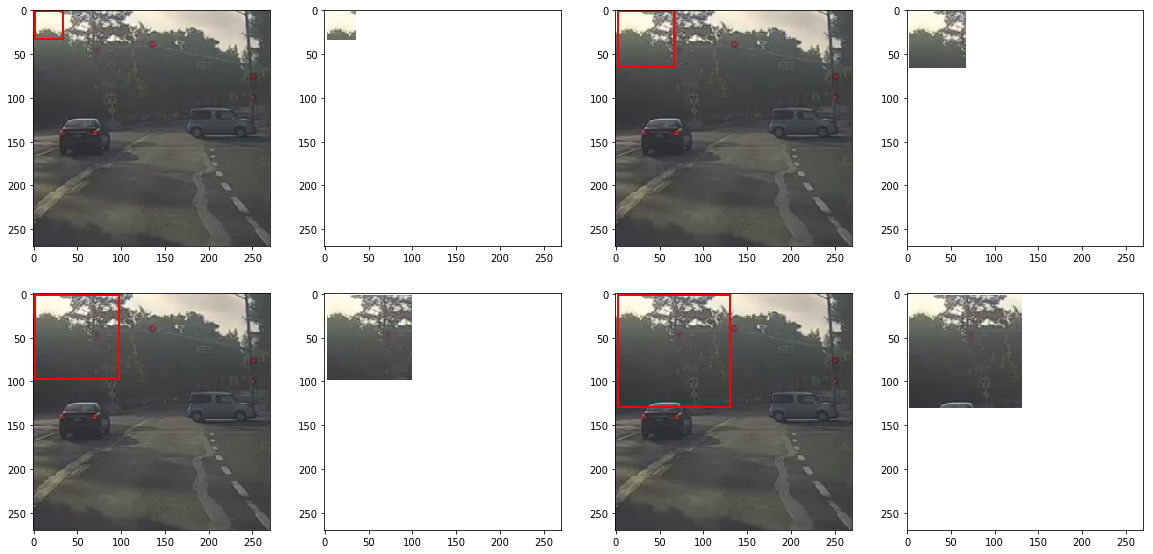

In [21]:
from IPython.display import HTML

fig = plt.figure(figsize=(20, 20))    
img = mpim.imread('./img/Detection_cars_nobb.png')
psize = 32
x, y = 1, 1

# небольшая лапша
def updatefig(*args):
    global x, y, psize
    x += 1
    if x > 50:
        y = 10
        x = 1
    ax = plt.subplot(4,4,1)
    ax.clear()
    im = plt.imshow(img, animated=True)
    rect = mpatches.Rectangle(
                (x, y), psize, psize, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    ax = plt.subplot(4,4,2)
    ax.clear()
    im = plt.imshow(img, animated=True)
    rect = mpatches.Rectangle(
                (x, y), psize, psize, fill=False, edgecolor='red', linewidth=2, transform=ax.transData)
    
    im.set_clip_path(rect)
    
    #
    ax = plt.subplot(4,4,3)
    ax.clear()
    im = plt.imshow(img, animated=True)
    rect = mpatches.Rectangle(
                (x, y), psize*2, psize*2, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)    
    ax = plt.subplot(4,4,4)
    ax.clear()
    im = plt.imshow(img, animated=True)
    rect = mpatches.Rectangle(
                (x, y), psize*2, psize*2, fill=False, edgecolor='red', linewidth=2, transform=ax.transData)
    
    im.set_clip_path(rect)

    #
    ax = plt.subplot(4,4,5)
    im = plt.imshow(img, animated=True)
    rect = mpatches.Rectangle(
                (x, y), psize*3, psize*3, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax = plt.subplot(4,4,6)
    ax.clear()
    im = plt.imshow(img, animated=True)
    rect = mpatches.Rectangle(
                (x, y), psize * 3, psize * 3, fill=False, edgecolor='red', linewidth=2, transform=ax.transData)
    
    im.set_clip_path(rect)
    
    #
    ax = plt.subplot(4,4,7)
    im = plt.imshow(img, animated=True)
    rect = mpatches.Rectangle(
                (x, y), psize*4, psize*4, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    ax = plt.subplot(4,4,8)
    ax.clear()
    im = plt.imshow(img, animated=True)
    rect = mpatches.Rectangle(
                (x, y), psize * 4, psize * 4, fill=False, edgecolor='red', linewidth=2, transform=ax.transData)
    
    im.set_clip_path(rect)
    
    return im,

anim = animation.FuncAnimation(fig, updatefig, interval=100, blit=True, repeat=True)
#plt.show()
#HTML(anim.to_html5_video())

Теперь из получившегося мнощества предсказаний можем выбрать самое лучшее по вероятности класса, это и будут наши искомые объекты.

Проблема в том, что такой метод будет работать очень долго, для обработки одной картинки, требуется извлечь большое количество патчей

## Sliding windows при помощи конволюционной сети 

Рассмотрим, например, такую сверточную сеть. Задача которой - классификатор на четыре класса
![Segmentation](./img/Detection_conv_net.png)

In [52]:
"""
Скетч нейросети для такой классификции
"""
class Net14x14(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(nn.Conv2d(3, 16, kernel_size=5, stride=1), # конволюция 
                                 nn.MaxPool2d(kernel_size=2,stride=2), # мах pooling                                 
                                )
        # ....
        self.linear_input = 5 * 5 * 16 # размер финального слоя CNN -> count_features x out_W x out_H
        self.classes = nn.Sequential(nn.Linear(self.linear_input,self.linear_input),
                                     nn.Linear(self.linear_input, 4)) # два класса 
        
    def forward(self, x):
        o = self.net(x)
        o = o.view(-1, self.linear_input)
        return self.classes(o) # возвращаем logit'ы для оценки, при помощи nn.Softmax()

Теперь посмотрим, что будет с картинкой, когда мы пропустим ее через сеть. Важно, что мы расчитали, что наша сеть получает на вход изображение размером $14 \times 14$

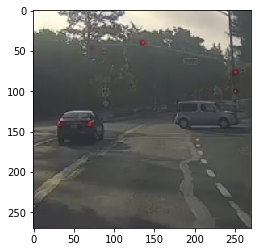

In [68]:
import torchvision as tv
from PIL import Image
img = Image.open('./img/Detection_cars_nobb.png')
plt.imshow(img)


In [25]:
x = tv.transforms.ToTensor()(img)
print ('Текущий размер картинки, который не проглотит наша сеть.', x.size())

Текущий размер картинки, который не проглотит наша сеть. torch.Size([3, 270, 270])


In [54]:
net = Net14x14()
# проблема, в линейном слое, линейный слой имеет окраниченную размерность матрицы, поэтому нам нужно образать картинку до
# 14x14
x_14x14 = x[:, :14, :14]
out = net.forward(x_14x14.unsqueeze(0))
print("Размер выхода сети", out.size())

Размер выхода сети torch.Size([1, 4])


Но можно использовать свойсва сверток и отказаться от FC заменив их на свертки вот так:
![Segmentation](./img/Detection_conv_net2.png)
Что в принципе справедливо, поскольку мы конвертируем выход последнего сверточного слоя линейной трансформацией .view()

In [61]:
"""
Скетч нейросети для такой классификции
"""
class Net14x14_ful_conv(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(nn.Conv2d(3, 16, kernel_size=5, stride=1), # конволюция 
                                 nn.MaxPool2d(kernel_size=2,stride=2), # мах pooling
                                 nn.Conv2d(16, 400, kernel_size = 5, stride=1), # заменяем FC 1
                                 nn.Conv2d(400, 400, kernel_size = 1, stride=1), # заменяем FC 2
                                 nn.Conv2d(400, 4, kernel_size = 1, stride=1) # заменяем классификатор
                                )

        
    def forward(self, x):
        return self.net(x) # возвращаем logit'ы для оценки, при помощи nn.Softmax()

In [62]:
net = Net14x14_ful_conv()
x_14x14 = x[:, :14, :14]
out = net.forward(x_14x14.unsqueeze(0))
print("Размер выхода сети", out.size())

Размер выхода сети torch.Size([1, 4, 1, 1])


Ничего не изменилось, добавились только доп размерности. Теперь мы можем применить сеть к полному изображению.

In [63]:
out = net.forward(x.unsqueeze(0))
print("Размер выхода сети", out.size())

Размер выхода сети torch.Size([1, 4, 129, 129])


Что происходит, когда мы применяем нашу сеть на картинку большего размера?
![Segmentation](./img/Detection_conv_net3.png)
Поскольку конволюция сохраняет пространственное положение после преобразования, то на выходе мы можем соотнести финальные активации сети с частью входного изображения:
* красный 
* зеленый
* фиолетовый
* желтый 
Регионы на входе соответствуют, красному, зеленому, фиолетовому и желтым регионам на входе. Каждый регион, таким образом, аннотируется классификатором, размерностью x4.

Для нашего входного изображения мы получили 129x129 регионов с классификатором.

Теперь мы можем при помощи конволюционной сети и sliding windows, получить разметку каждого региона изображения размером 14x14

![Segmentation](./img/Detection_car_sliding.png)

# Предсказываем Bounding Box


## Проблема точности sliding window
Если мы используем скользящее окно, то мы сталкиваемся с множеством проблем связанным с точностью определения позиции ограничивающего прямоугольника вокруг объекта. Это связанно как с точностью позиционирования, так и с размерами самого объекта.

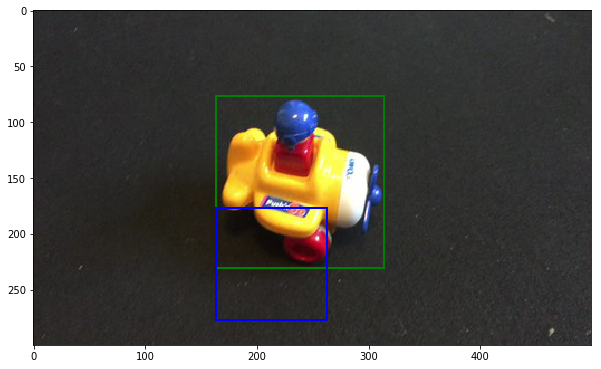

In [15]:
size = 8
# берем size случайных картинок
plt.figure(figsize=(10, 15))
#имя файла это индекс в дата сете
idx = image_files[1]    
ax = plt.subplot(1,1,1) 
# читаем b gjrfpsdftv rfhnbyrb 
img = mpim.imread(os.path.join(IMAGES, idx + '.jpg'))
ax.imshow(img)
# задаем положение bb
x, y, w, h = data.loc[idx]['xmin'], data.loc[idx]['ymin'], data.loc[idx]['xmax'], data.loc[idx]['ymax']
w, h = w - x, h-y
rect = mpatches.Rectangle(
        (x, y), w, h, fill=False, edgecolor='green', linewidth=2)
ax.add_patch(rect)

x, y, w, h = data.loc[idx]['xmin'], data.loc[idx]['ymin'], data.loc[idx]['xmax'], data.loc[idx]['ymax']
w, h = w - x, h-y
rect = mpatches.Rectangle(
        (x, y), w, h, fill=False, edgecolor='green', linewidth=2)
ax.add_patch(rect)

rect = mpatches.Rectangle(
        (x, y+100), 100, 100, fill=False, edgecolor='blue', linewidth=2)
ax.add_patch(rect)



## Алгоритм YOLO
Основная идея алгоритма базируется на идее "sliding window", но в отличии алгоритм предполагает не динамическую генерацию выходов сети, а сделать статическое мапирование выходов сети на изображение. Таким образом мы получаем сетку, наложенную на изображение, в которой каждый элемент сетки соответствует соответсвует выходу сети.

![Segmentation](./img/Yolo_Grid.jpg)

### Таргет.
Для элементов сетки, которые не содержат не одного центра ограничивающего прямоугольника

$ \ \large y = \left[ 0, ?, ?, ?, ?, ?, ?, ? \right]$

Для элементов, которые содержат центр ограничивающего прямоугольника для объекта

$ \ \large y = \left[ 1, b_x, b_y, b_w, b_h, с_1, ... ,c_k \right]$

1. Координаты ограничивающего прямоугольника задаются относительно ячейки, в которую попадает центр ограничивающего прямоугольника
2. Координаты центра задаются в диапазоне 0-1. Верхний левый угол ячейки имеет координаты $(0,0)$, правый нижний угол ячейки имеет координаты $(1,1)$. $ 0 < {b_x, b_y} < 1$
3. Размеры ограничивающего прямоугольника $b_h, b_w$ задаются относительно ширины и высоты ячейки. $ 0 < { b_h, b_w } < ...  $

### Пример
Для четырех классов размер выхода сети будет равен $3x3x8$

### Сама сеть Yolo

1. Вход сети, это выход предобученной ResNet18 512x7x7, т.е. мы имеем 512 каналов на входе и размер сетки 7x7 элементов
2. ResNet18 - мы дообучать не будем, поэтому переопределим метод parameters, который ставит блокировку прохождения градиента.
3. Выход Yolo $12x7x7$. $12 = 2x(p_c, b_x,b_y,b_h,b_w,c_1)$

In [ ]:
'''
Пример сети YOLO
'''
class YoloNet(nn.Module):
    
    def __init__(self, pretrained_net, in_channels=512):
        """
        Размер нашей сетки в этой задаче 
        Arguments
        pretrained_net - в оригинальной статье использовали предобученная сеть, одна из причин, это небольшое количество
                         размеченных данных
        in_channels - в предобученной сети мы убираем классификационный FC слой и оставляем верхние свертки.
                      это количество каналов, которое мы получим из предобученной сетки.                      
        """
        super().__init__()
        self.pretrained_net = pretrained_net
        self.net = nn.Sequential(nn.Conv2d(in_channels, 512, kernel_size=3, stride=1, padding=1),
                                 nn.BatchNorm2d(512),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout2d(0.5),
                                 nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
                                 nn.BatchNorm2d(1024),
                                 nn.ReLU(inplace=True),
                                 nn.Dropout2d(0.5),
                                 nn.Conv2d(1024, 12, kernel_size=3, stride=1, padding=1),
                                )
    
    def parameters(self):
        # оптимизируем только добавку без претрайна ResNet
        # морозим градиенты
        params =  self.pretrained_net.parameters()
        for param in params:
            param.requires_grad = False # блокируем расчет градиента

        return self.net.parameters() # возвращаем тлолько наши параметры

    def forward(self, x):
        x = self.pretrained_net(x)
        return self.net(x)

![Segmentation](./img/Yolo_Scheme.png)

# Intersection over Union IoU
Когда мы освоили примитивны метод декции множества объектов на изображении, хочется понять как оценивать качество детекции. Для этих целей существует метрика, которая замеряет разницу между предсказанными $\hat{bb}$ и таргетами $bb$.

$\large IoU = \frac {\hat{bb}\ \cap\ bb}{\hat{bb}\ \cup \ bb}$

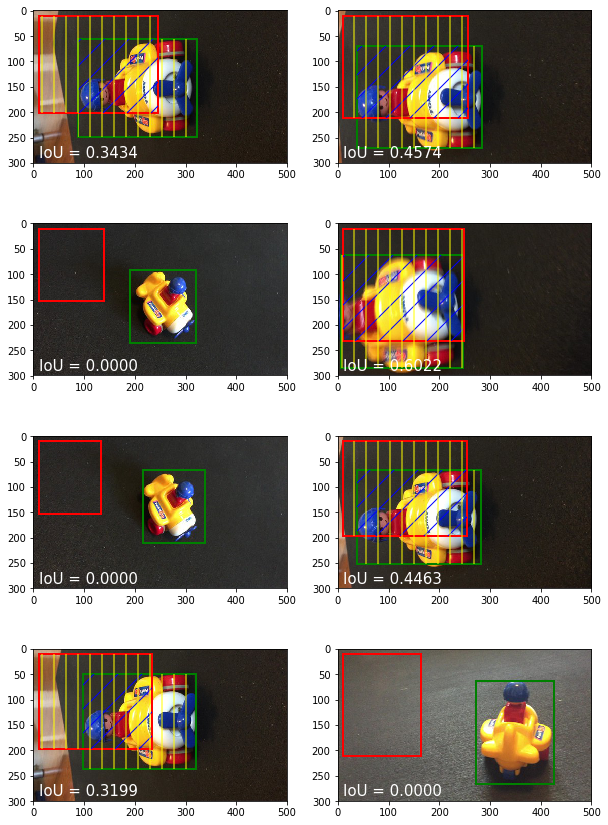

In [177]:
from shapely.geometry import Polygon
size = 8
# берем size случайных картинок
sample = np.random.choice(np.linspace(0, len(image_files)-1, len(image_files), dtype=int), replace=False, size=size)
plt.figure(figsize=(10, 15))
for num in range(1, size+1):
    #имя файла это индекс в дата сете
    idx = image_files[sample[num-1]]    
    ax = plt.subplot(4,2,num) 
    # читаем b gjrfpsdftv rfhnbyrb 
    img = mpim.imread(os.path.join(IMAGES, idx + '.jpg'))
    ax.imshow(img)
    # задаем положение bb
    x, y, w, h = data.loc[idx]['xmin'], data.loc[idx]['ymin'], data.loc[idx]['xmax'], data.loc[idx]['ymax']
    w, h = w - x, h-y
    # рисуем таргет bb
    rt = Polygon([(x, y), ((x+w), y), ((x+w), (y+h)), ((x), (y+h))])
    rect_target = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect_target)
    
    # ресуем то, что "предсказали" 
    rp = Polygon([(10, 10), ((10+w), 10), ((10+w), (10+h)), ((10), (10+h))])    
    rect_predict = mpatches.Rectangle(
            (10, 10), w, h, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect_predict)
    
    # рисуем пересечение
    i = 0
    u = 0
    if rt.intersects(rp):
        ir = rt.intersection(rp)
        intersect = mpatches.Polygon(
                list(ir.exterior.coords), fill=False, edgecolor='blue', hatch='/', linewidth=0)
        ax.add_patch(intersect)
        i = ir.area

        # объединение
        un = rt.union(rp)
        union = mpatches.Polygon(
                   list(un.exterior.coords), fill=False, edgecolor='yellow', hatch='|',  linewidth=0)
        ax.add_patch(union)
        u = un.area
        
    ax.text(10,290, "IoU = %0.4f"% (i/(u+0.0001)), color='white', fontsize=15)


# Non-maximum Suppression
Одна из задач, с которой сталкиваются алгоритмы определения объектов на изображении - это, то, что на один объект можно получить множество гипотез с ограничевающими прямоугольниками. В этом случае мы можем применить алгоритм *Non-max Suppression*, что бы убрать не нужные bounding box'ы

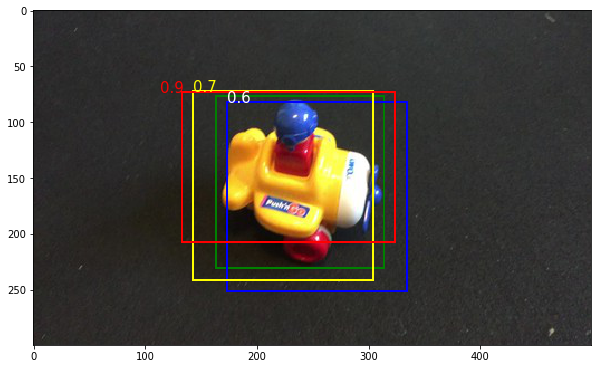

In [191]:
size = 8
# берем size случайных картинок
plt.figure(figsize=(10, 15))
#имя файла это индекс в дата сете
idx = image_files[1]    
ax = plt.subplot(1,1,1) 
# читаем b gjrfpsdftv rfhnbyrb 
img = mpim.imread(os.path.join(IMAGES, idx + '.jpg'))
ax.imshow(img)
# задаем положение bb
x, y, w, h = data.loc[idx]['xmin'], data.loc[idx]['ymin'], data.loc[idx]['xmax'], data.loc[idx]['ymax']
w, h = w - x, h-y
rect = mpatches.Rectangle(
        (x, y), w, h, fill=False, edgecolor='green', linewidth=2)
ax.add_patch(rect)
rect = mpatches.Rectangle(
        (x+10, y+5), w+10, h+15, fill=False, edgecolor='blue', linewidth=2)
ax.text(x+10, y+5, "0.6", color='white', fontsize=15)

ax.add_patch(rect)
rect = mpatches.Rectangle(
        (x-20, y-5), w+10, h+15, fill=False, edgecolor='yellow', linewidth=2)
ax.text(x-20, y-5, "0.7", color='yellow', fontsize=15)

ax.add_patch(rect)
rect = mpatches.Rectangle(
        (x-30, y-4), w+40, h-20, fill=False, edgecolor='red', linewidth=2)
ax.text(x-50, y-4, "0.9", color='red', fontsize=15)

ax.add_patch(rect)

Для каждого выходного вектора bb мы будем иметь, следующие параметры
$\large y=[p_c, b_x, b_y, b_w, b_h, c_1, ..., c_n]$
1. Убираем все bb с вероятностью меньше заданной, обычно $p_c \leq 0.6$
2. Для всех оставшихся bb отбираем bb с максимальной вероятностью, в данном случае красный bb, у него $p_c=0.9$
3. Все bb, у которых $ IoU > 0.5 $ с лучшим отбрасываем, т.е. убираем из дальнейшего рассмотрения.
4. Если у нас количество объектов на изображении больше 1, то повторяем процедуру для следующего  bb с максимальным $p_c$
5. Если мы определяем больше одного класса, то повторяем эту процедуру для каждого класса

### Пример с несколькими объектами
![Segmentation](./img/Detection_car_non_sup.png)

# Anchor Boxes
Следующая проблема, с которой сталкиваются в задаче детекции объектов - это, что делать если у нас в центр нашего обрамляющего прямоугольника попадает не один объект, а несколько?
![Segmentation](./img/Detection_car_anchor.png)

1. Разделяем нашу входное изображение на логические области, благо, это заложено в архитектуре CNN, см. примеры выше. (Например, мы может взять шаг равный размеру окна)
2. С каждой областью мы связываем центр, объекта (центр, ограничивающего прямоугольника).
3. С каждой областью мы связываем не один bb, а несколько, например, два.

![Segmentation](./img/Detection_anchor2.png)

4. Мы определяем анкоры различной формы

![Segmentation](./img/Detection_anchor3.png)

Таким образом выход нашей сети будет содержать следующий набор значений:
$\large y=[p_c^1, b_x^1, b_y^1, b_w^1, b_h^1, c_1^1, ..., c_n^1,p_c^2, b_x^2, b_y^2, b_w^2, b_h^2, c_1^2, ..., c_n^2]$

где верхний индекс значит id анкора.

__Таким образом, каждый объект на картинке привызывается к логической области, если центр объекта попадает в данную область. Этому объекту назначается anchor box с максимальным IoU.__

Суммарный выход получившейся сети с логическим разбиением 3x3, например, для детекции трех классов будет равен __3x3x16__


# Yolo. Putting all together.
Теперь мы подошли к тому, что бы написать собственную сетку по детекции объектов.

Допустим, мы хотим детектить объекты трех классов:
1. Пешеход
2. Авто
3. Мотоцикл

Определяем выход сетки
$\large y=[p_c^1, b_x^1, b_y^1, b_w^1, b_h^1, c_1^1, с_2^1, с_3^1, c_n^1,p_c^2, b_x^2, b_y^2, b_w^2, b_h^2, c_1^1, с_2^1, с_3^1]$

Итого 16 значений на один логический элемент сетки 

## Тренировка
![Segmentation](./img/Detection_yolo_train.png)

Для синего квадрата, где нет разметки объектов, выходной вектор получается следующий:

$ \large y=[0,?, ?, ?, ?, ?, ?, ?, ?,?, ?, ?, ?, ?, ?, ?, ?]$

Для квадрата с объектом, отбираем anchor bb c максимальным перекрытием IoU с таргетом:

$ \large y=[0, ?, ?, ?, ?, ?, ?, ?, 1, b_x^2, b_y^2, b_w^2, b_h^2 , 0, 1, 0]$


## Предсказание
![Segmentation](./img/Detection_yolo3.png)

Для синего квадрата, где нет объектов, выходной вектор получается следующий:

$ \large y=[0,?, ?, ?, ?, ?, ?, ?, ?,?, ?, ?, ?, ?, ?, ?, ?]$

Для квадрата с объектом:

$ \large y=[0, ?, ?, ?, ?, ?, ?, ?, 1, b_x^2, b_y^2, b_w^2, b_h^2 , 0, 1, 0]$

# Non-maximum Suppression
![Segmentation](./img/Detection_yolo4.png)
1. Для каждого элемента сетки получим два bb на выходе
2. Отбросим все bb с низкой вероятностью см. выше
![Segmentation](./img/Detection_yolo5.png)
3. Для каждого класса используем _Non-maximum Suppression_ для генерации финального вывода


# Литература
1. [YOLO - оригинальная статья по yolo. Без опорных прямоугольников](https://arxiv.org/abs/1506.02640)
2. [YOLOv2](https://arxiv.org/abs/1612.08242)
3. [deeplearning.ai Небольшой курс по сверточным сетям от Andrew Ng](https://www.youtube.com/watch?v=ArPaAX_PhIs&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF)